In [1]:
import csv
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras import regularizers


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def get_dataset():
    # Fetch dataset, keep 'close' prices
    hourly_prices = []
    r = csv.DictReader(open('Gemini_BTCUSD_1h.csv'))
    for x in r:
        price = float(x['Close'])
        hourly_prices.append(price)
    hourly_prices.reverse()
    return hourly_prices

In [3]:
def split_dataset(dataset):
    # Split into train/dev/test sets
    traindata = dataset[:int(len(dataset)*8/10)]
    devdata   = dataset[int(len(dataset)*8/10):int(len(dataset)*9/10)]
    testdata  = dataset[int(len(dataset)*9/10):]
    return traindata, devdata, testdata

In [4]:
def visualize_datasets(traindata, devdata, testdata):
    # Display train/dev/test sets
    idx_dev_start = len(traindata); idx_dev_end = len(traindata) + len(devdata)
    idx_test_start = idx_dev_end; idx_test_end = idx_dev_end + len(testdata)

    plt.figure(); 
    plt.plot(range(len(traindata)), traindata, label='Train'); plt.legend()
    plt.plot(range(idx_dev_start, idx_dev_end), devdata, label='Dev')
    plt.plot(range(idx_test_start, idx_test_end), testdata, label='Test')
    plt.legend(); plt.show()

In [5]:
def preprocess(data):
    values = np.array(data)
    values = values.reshape(-1,1)
    values = values.astype('float32') 
    return values

In [6]:
def fit_scaler(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit(preprocess(data))
    return scaler

In [7]:
def transform(data, fitted_scaler):
    return fitted_scaler.transform(preprocess(data))

In [8]:
def inverse_transform(data, fitted_scaler):
    return fitted_scaler.inverse_transform(preprocess(data))

In [9]:
def create_labeled_data(data, lag=10):
    X, Y = [], []
    for i in range(len(data)-lag-1):
        X.append(data[i:i+lag])
        Y.append(data[i+lag])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [10]:
def plot_losses(model_history, title):
    plt.figure()
    plt.plot(model_history.history['loss'], label='Train')
    plt.plot(model_history.history['val_loss'], label='Dev')
    plt.xlabel('Epochs'); plt.ylabel('Loss (mse)')
    plt.title(title)
    plt.legend(); plt.show()

In [11]:
def plot_predictions(model, X_test, Y_test, title, inverse=False, scaler=None):
    y_hat = model.predict(X_test)
    
    if inverse:
        y_hat = inverse_transform(y_hat, scaler)
        Y_test = inverse_transform(Y_test, scaler)

    plt.plot(y_hat, label='Predicted')
    plt.plot(Y_test, label='True')
    plt.xlabel('Time'); 
    
    if inverse:
        plt.ylabel('Price')
    else:
        plt.ylabel('RESCALED Price')
        
    plt.title(title)
    plt.legend(); plt.show()

In [12]:
def calculate_MSE_RMSE(model, scaler, X_test, Y_test, model_name):
    y_hat = model.predict(X_test)
    y_hat_inverse = inverse_transform(y_hat, scaler)
    Y_test_inverse = inverse_transform(Y_test, scaler)
    mse = mean_squared_error(Y_test_inverse, y_hat_inverse)
    rmse = np.sqrt(mean_squared_error(Y_test_inverse, y_hat_inverse))
    print('%s:' % model_name)
    print('Test MSE: %.3f' % mse)
    print('Test RMSE: %.3f' % rmse)
    print()

In [13]:
def train_evaluate(model, model_name, 
                   X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    
    # Train model
    history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                        validation_split=0.05, verbose=verbose, shuffle=False)

    # Plot losses, predictions, and calculate MSE and RMSE
    plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_dev, Y_dev, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=scaler)
    calculate_MSE_RMSE(model, scaler, X_dev, Y_dev, '%s' % model_name)

In [14]:
def evaluate_test(model, model_name, 
                   X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
                   lag=10, batch_size=100, epochs=10, verbose=1):
    
    # Train model
    #history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
    #                    validation_split=0.05, verbose=verbose, shuffle=False)

    # Plot losses, predictions, and calculate MSE and RMSE
    #plot_losses(history, 'Loss\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, 'Test Predictions\n(%s)' % model_name)
    plot_predictions(model, X_test, Y_test, 'Test Predictions\n(%s)' % model_name, inverse=True, scaler=scaler)
    calculate_MSE_RMSE(model, scaler, X_test, Y_test, '%s' % model_name)

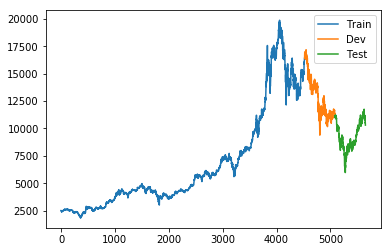

In [15]:
# Fetch dataset, split into trai/dev/test, visualize
hourly_prices = get_dataset()
traindata, devdata, testdata = split_dataset(hourly_prices)
visualize_datasets(traindata, devdata, testdata)

# Fit scaler on train data, then rescale train/dev/test data accordingly
scaler = fit_scaler(traindata)
traindata_rescaled = transform(traindata, scaler)
devdata_rescaled   = transform(devdata, scaler)
testdata_rescaled  = transform(testdata, scaler)

In [16]:
# HYPERPARAMETERS
#####################
lag = 1
loss = 'mean_squared_error'
optimizer = 'adagrad' # sgd, adagrad, adam, rmsprop, adadelta, adamax, nadam
batch_size = 100
epochs = 10
model_name = 'model_LAG-%s_LOSS-%s_OPT-%s_BATCHSIZE-%s_EPOCHS-%s' % (lag, loss, optimizer, batch_size, epochs)
#####################

# Create labeled data, according to lag
X_train, Y_train = create_labeled_data(traindata_rescaled, lag)
X_dev, Y_dev     = create_labeled_data(devdata_rescaled, lag)
X_test, Y_test   = create_labeled_data(testdata_rescaled, lag)
LSTM_input_shape = [X_train.shape[1], X_train.shape[2]]

In [17]:
# DEFINE MODEL
model = Sequential()

##################### 
for x in range(3):
  model.add(LSTM(256, input_shape=LSTM_input_shape, return_sequences=True))
  #model.add(LSTM(256, input_shape=LSTM_input_shape, return_sequences=True))
  #model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=False))
#model.add(Dropout(0.1))

model.add(Dense(1))
#model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01)))

model.add(Activation('linear'))
#####################

model.compile(loss=loss, optimizer=optimizer)

Train on 4292 samples, validate on 226 samples
Epoch 1/10
4292/4292 [==============================] - 3s 597us/step - loss: 0.0200 - val_loss: 0.0078
Epoch 2/10
4292/4292 [==============================] - 0s 114us/step - loss: 0.0234 - val_loss: 0.0015
Epoch 3/10
4292/4292 [==============================] - 1s 124us/step - loss: 0.0157 - val_loss: 7.9095e-04
Epoch 4/10
4292/4292 [==============================] - 1s 121us/step - loss: 0.0058 - val_loss: 3.5892e-04
Epoch 5/10
4292/4292 [==============================] - 0s 116us/step - loss: 0.0015 - val_loss: 2.1667e-04
Epoch 6/10
4292/4292 [==============================] - 1s 126us/step - loss: 2.8756e-04 - val_loss: 1.7891e-04
Epoch 7/10
4292/4292 [==============================] - 0s 116us/step - loss: 7.8463e-05 - val_loss: 1.6748e-04
Epoch 8/10
4292/4292 [==============================] - 1s 123us/step - loss: 5.0814e-05 - val_loss: 1.6486e-04
Epoch 9/10
4292/4292 [==============================] - 1s 127us/step - loss: 4.7353e

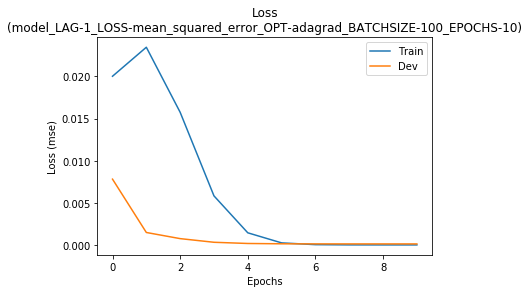

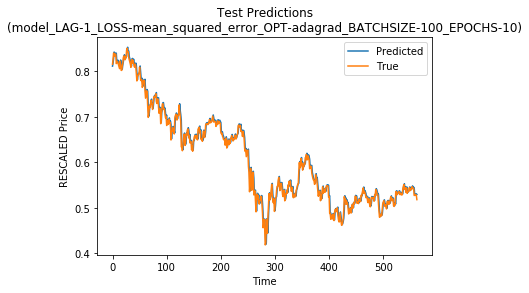

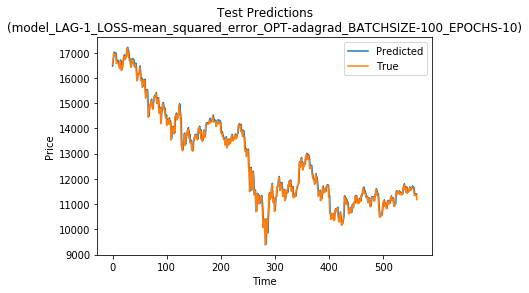

model_LAG-1_LOSS-mean_squared_error_OPT-adagrad_BATCHSIZE-100_EPOCHS-10:
Test MSE: 45373.039
Test RMSE: 213.009



In [18]:
# Train/evaluate model
train_evaluate(model, model_name,
               X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
               lag=lag, batch_size=batch_size, epochs=epochs, verbose=1)

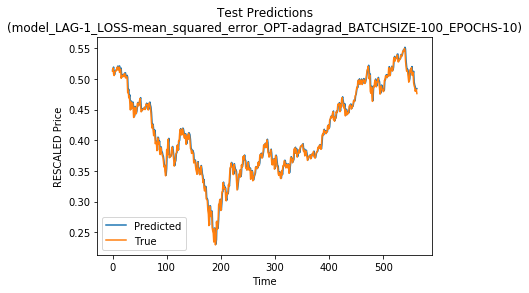

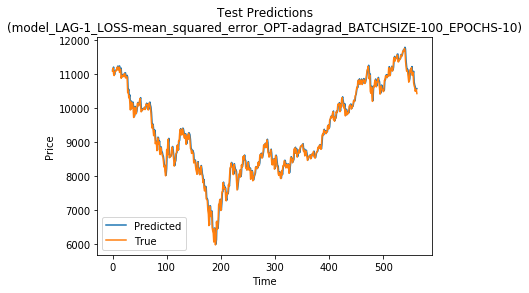

model_LAG-1_LOSS-mean_squared_error_OPT-adagrad_BATCHSIZE-100_EPOCHS-10:
Test MSE: 21490.309
Test RMSE: 146.596



In [19]:
# Train/evaluate model
evaluate_test(model, model_name,
               X_train, Y_train, X_dev, Y_dev, X_test, Y_test,
               lag=lag, batch_size=batch_size, epochs=epochs, verbose=1)